In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# Install required libraries
!pip install transformers scikit-learn pandas torch peft umap-learn

In [18]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader, Dataset


# Load LLM

In [19]:
# Load ClinicalT5 model
model_name = "Shijia/ClinicalT5-base-finetuned-biomedical"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Load File

In [20]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-train.csv"
val_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-val.csv"
test_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM-no-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

In [21]:
# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['disease_label'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['disease_label'] = label_encoder.transform(val_data['disease_label'])
test_data['disease_label'] = label_encoder.transform(test_data['disease_label'])


# LoRA (Low-Rank Adaptation)

In [22]:
# Without LoRA, performance is even better
"""
# Apply LoRA adaptation to ClinicalT5
lora_config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "encoder.block.0.layer.0.SelfAttention.q",
        "encoder.block.0.layer.0.SelfAttention.v",
        "encoder.block.1.layer.0.SelfAttention.q",
        "encoder.block.1.layer.0.SelfAttention.v",
        "encoder.block.2.layer.0.SelfAttention.q",
        "encoder.block.2.layer.0.SelfAttention.v",
        "decoder.block.0.layer.0.SelfAttention.q",
        "decoder.block.0.layer.0.SelfAttention.v",
        "decoder.block.1.layer.0.SelfAttention.q",
        "decoder.block.1.layer.0.SelfAttention.v",
        "decoder.block.2.layer.0.SelfAttention.q",
        "decoder.block.2.layer.0.SelfAttention.v"
    ],
    lora_dropout=0.2,
    task_type="SEQ_2_SEQ_LM"
)
model = get_peft_model(model, lora_config)
print("LoRA applied successfully!")
"""

'\n# Apply LoRA adaptation to ClinicalT5\nlora_config = LoraConfig(\n    r=32,\n    lora_alpha=64,\n    target_modules=[\n        "encoder.block.0.layer.0.SelfAttention.q",\n        "encoder.block.0.layer.0.SelfAttention.v",\n        "encoder.block.1.layer.0.SelfAttention.q",\n        "encoder.block.1.layer.0.SelfAttention.v",\n        "encoder.block.2.layer.0.SelfAttention.q",\n        "encoder.block.2.layer.0.SelfAttention.v",\n        "decoder.block.0.layer.0.SelfAttention.q",\n        "decoder.block.0.layer.0.SelfAttention.v",\n        "decoder.block.1.layer.0.SelfAttention.q",\n        "decoder.block.1.layer.0.SelfAttention.v",\n        "decoder.block.2.layer.0.SelfAttention.q",\n        "decoder.block.2.layer.0.SelfAttention.v"\n    ],\n    lora_dropout=0.2,\n    task_type="SEQ_2_SEQ_LM"\n)\nmodel = get_peft_model(model, lora_config)\nprint("LoRA applied successfully!")\n'

In [23]:
# Tokenization function
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Tokenize dataset
train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
train_labels_encodings = tokenize_texts(train_data['disease_label'].astype(str))
val_labels_encodings = tokenize_texts(val_data['disease_label'].astype(str))

# Dataset class
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels_encodings):
        self.encodings = encodings
        self.labels_encodings = labels_encodings

    def __len__(self):
        return len(self.labels_encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels_encodings['input_ids'][idx]
        return item

train_dataset = SymptomDataset(train_encodings, train_labels_encodings)
val_dataset = SymptomDataset(val_encodings, val_labels_encodings)


# Fine-tuning ClinicalT5

In [26]:
# Fine-tuning ClinicalT5
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=128,
    num_train_epochs=7,
    weight_decay=0.001,
    gradient_accumulation_steps=4,
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [27]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,1.299400,0.010239
2,0.118600,0.003287
3,0.053000,0.001626
4,0.031300,0.002049
5,0.021800,0.001805
6,0.010500,0.001564


TrainOutput(global_step=4088, training_loss=0.191286059260485, metrics={'train_runtime': 2035.55, 'train_samples_per_second': 128.559, 'train_steps_per_second': 2.008, 'total_flos': 2.051133832839168e+16, 'train_loss': 0.191286059260485, 'epoch': 6.989302524604193})

# Generate ClinicalT5 Embedding for MLs

In [28]:
# Inference function
def predict_disease(symptoms):
    input_text = "predict disease: " + symptoms
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        output = model.generate(**inputs)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Generate embeddings
def generate_t5_embeddings(data, column, batch_size=16):
    dataset = [text for text in data[column].tolist()]
    all_embeddings = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
        with torch.no_grad():
            encoder_outputs = model.encoder(**inputs)
            embeddings = encoder_outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

train_embeddings = generate_t5_embeddings(train_data, "symptoms")
val_embeddings = generate_t5_embeddings(val_data, "symptoms")
test_embeddings = generate_t5_embeddings(test_data, "symptoms")

# Apply PCA before ML classification
pca = PCA(n_components=50)
train_embeddings_pca = pca.fit_transform(train_embeddings)
val_embeddings_pca = pca.transform(val_embeddings)
test_embeddings_pca = pca.transform(test_embeddings)


# UMAP (Uniform Manifold Approximation and Projection)



Reducing dimensions using UMAP...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


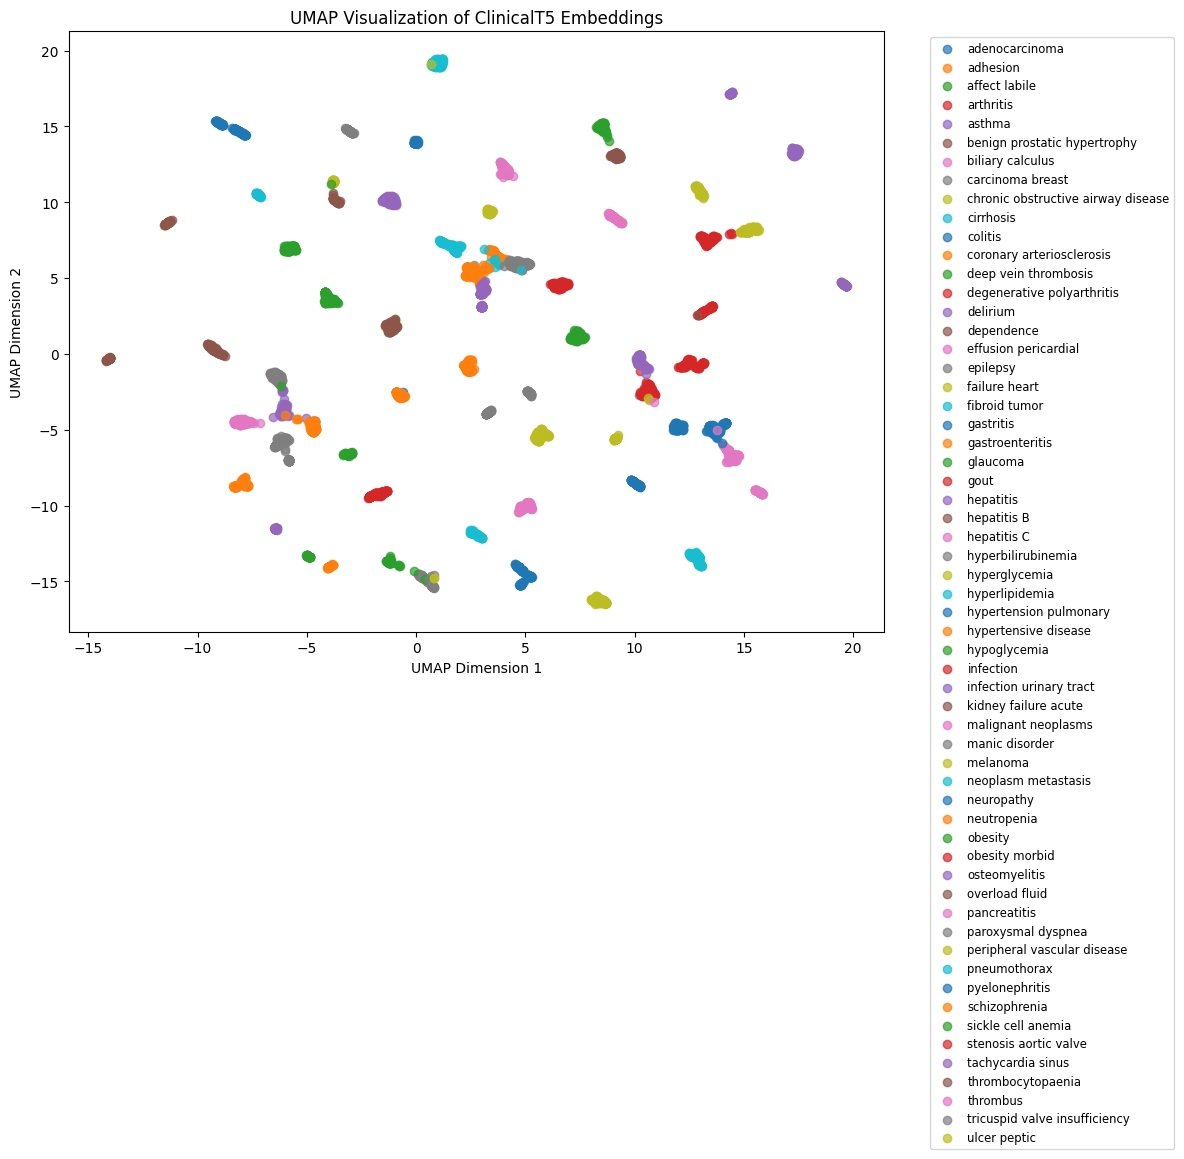

In [29]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np

# Generate test embeddings (ensure this is executed before using UMAP)
# test_embeddings should already be generated using your generate_embeddings function.
test_labels = torch.tensor(test_data['disease_label'].values, device=device)

# Convert test labels to NumPy for easier handling
labels = test_labels.cpu().numpy()  # Ensure this is defined and matches the test dataset

# Reduce dimensions using UMAP
print("Reducing dimensions using UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(test_embeddings)

# Map numeric labels to disease names
disease_names = label_encoder.inverse_transform(labels)  # Map numeric labels to actual disease names

# Plot the 2D representation
plt.figure(figsize=(12, 10))
unique_labels = np.unique(disease_names)

for disease in unique_labels:
    indices = np.where(disease_names == disease)
    plt.scatter(
        reduced_embeddings[indices, 0], reduced_embeddings[indices, 1],
        label=disease, alpha=0.7
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.title("UMAP Visualization of ClinicalT5 Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.tight_layout()
plt.show()


# Naive Bayes

In [30]:
# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = nb_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = nb_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))

Validation Report:
           adenocarcinoma    adhesion  affect labile   arthritis     asthma  \
precision        1.000000    0.974684       1.000000    1.000000   1.000000   
recall           0.962264    0.962500       0.826667    0.910569   0.802817   
f1-score         0.980769    0.968553       0.905109    0.953191   0.890625   
support        159.000000  160.000000      75.000000  123.000000  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.918239          0.993865   
recall                         0.813333          1.000000          1.000000   
f1-score                       0.897059          0.957377          0.996923   
support                       75.000000        146.000000        162.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.982456    0.930636  ...   
recall                               0.941176    0.993827

In [31]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-nb-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-nb-class.csv


# Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest on Embeddings
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = rf_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = rf_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile  arthritis     asthma  \
precision        1.000000    1.000000       1.000000    1.00000   1.000000   
recall           0.987421    0.993750       0.933333    0.95122   0.943662   
f1-score         0.993671    0.996865       0.965517    0.97500   0.971014   
support        159.000000  160.000000      75.000000  123.00000  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      1.000000          0.993151          0.993865   
recall                         0.960000          0.993151          1.000000   
f1-score                       0.979592          0.993151          0.996923   
support                       75.000000        146.000000        162.000000   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                            0.991453    0.969880  ...   
recall                               0.974790    0.993827  ...

In [33]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-rf-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-rf-class.csv


# Support Vector Classifier

In [34]:
# Train Support Vector Classifier (SVC) on Embeddings
from sklearn.svm import SVC

svc_model = SVC(kernel='linear', random_state=42)
svc_model.fit(train_embeddings, train_data['disease_label'])

# Validate the Model
val_preds = svc_model.predict(val_embeddings)
val_report = classification_report(val_data['disease_label'], val_preds, target_names=label_encoder.classes_, output_dict=True)
print("Validation Report:")
print(pd.DataFrame(val_report))

# Test the Model
test_preds = svc_model.predict(test_embeddings)
test_report = classification_report(test_data['disease_label'], test_preds, target_names=label_encoder.classes_, output_dict=True)
print("Test Report:")
print(pd.DataFrame(test_report))


Validation Report:
           adenocarcinoma    adhesion  affect labile  arthritis     asthma  \
precision             1.0    1.000000            1.0        1.0   1.000000   
recall                1.0    0.993750            1.0        1.0   0.985915   
f1-score              1.0    0.996865            1.0        1.0   0.992908   
support             159.0  160.000000           75.0      123.0  71.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                           1.0          0.993197               1.0   
recall                              1.0          1.000000               1.0   
f1-score                            1.0          0.996587               1.0   
support                            75.0        146.000000             162.0   

           chronic obstructive airway disease   cirrhosis  ...  \
precision                                 1.0    0.993827  ...   
recall                                    1.0    0.993827  ...

In [35]:
# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-svc-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

Classification report saved to /content/drive/MyDrive/P2/T1/Dataset/non_overlapped/LLM + ML/clinicalT5-svc-class.csv
